# Horizontal access

This notebook tests the developement of the `CurveCWSFourier` class, and the related objective and penalty functions to optimize a vertical access port to the device.

In [1]:
from simsopt._core import load
from simsopt.geo import SurfaceRZFourier
from simsopt.geo import VerticalPortDiscrete

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp

%matplotlib widget

In [2]:
# Load the surface, assumed fixed in this notebook. 
surf = SurfaceRZFourier.from_vmec_input( 'input.scaled' )

nfp = surf.nfp
qpts_phi = np.linspace(0, 1/(2*nfp), 16)
qpts_theta = np.linspace(0, 1, 32)

vessel = SurfaceRZFourier(
    nfp = surf.nfp,
    mpol = surf.mpol,
    ntor = surf.ntor,
    stellsym = surf.stellsym,
    quadpoints_phi=qpts_phi,
    quadpoints_theta=qpts_theta,
    dofs = surf.dofs
)

bs = load( 'coils.wiedman.json' )
ncoils = 5
curves = [c.curve for c in bs.coils[0:2*ncoils] + bs.coils[-ncoils:]]


Text(0, 0.5, 'y')

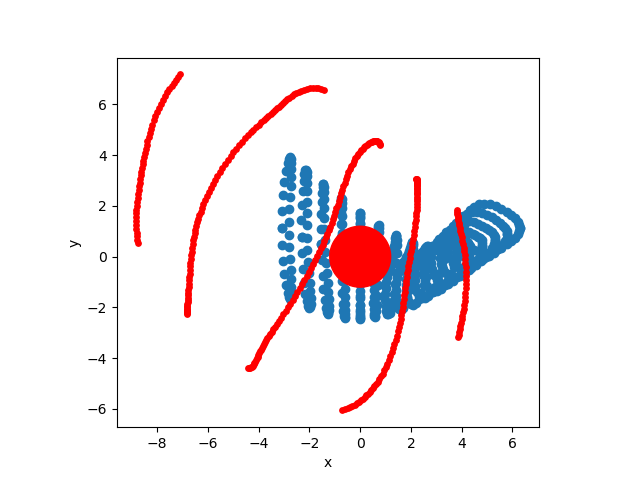

In [42]:
def project(x, x0):
    phic = jnp.arctan2(x0[1], x0[0])
    unit_normal = jnp.array([jnp.cos(phic), jnp.sin(phic), jnp.zeros(phic.shape)])
    unit_tangent = jnp.array([-jnp.sin(phic), jnp.cos(phic), jnp.zeros(phic.shape)])
    unit_z = jnp.array([jnp.zeros(phic.shape),jnp.zeros(phic.shape),jnp.ones(phic.shape)])

    M = jnp.array([unit_normal,unit_tangent,unit_z]).transpose()
    invM = jnp.linalg.inv(M)
    
    return jnp.einsum('ij,...j->...i',invM,x-x0)

iphi = 4
itheta = 0
x0 = vessel.gamma()[iphi,itheta,:]

gproj = project(vessel.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

rport = 1.2
l = np.linspace(0,2*np.pi,128,endpoint=True)
ax.fill(rport*np.cos(l), rport*np.sin(l), color='r')

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='r', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')


## CurveCWSFourier

This class represents a curve that lies on a surface. 

In [4]:
from simsopt.geo import CurveCWSFourier

In [53]:
order = 2
qpts = 128
curve_cws = CurveCWSFourier(
    qpts,
    order,
    vessel
)

curve_cws.set('phic(0)', 0.01)
curve_cws.set('phic(1)', 0.01)
curve_cws.set('thetac(0)', -0.1)
curve_cws.set('thetas(1)', 0.2)
#curve_cws.set('thetas(2)', -0.15)

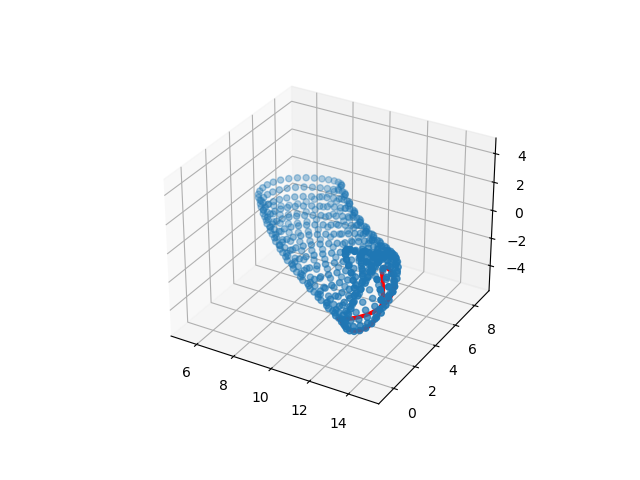

<Axes3D: >

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
g = vessel.gamma()
ax.scatter(g[...,0],g[...,1],g[...,2])
ax=plt.gca()
curve_cws.plot(ax=ax,color='r',linewidth=3)

Text(0, 0.5, 'y')

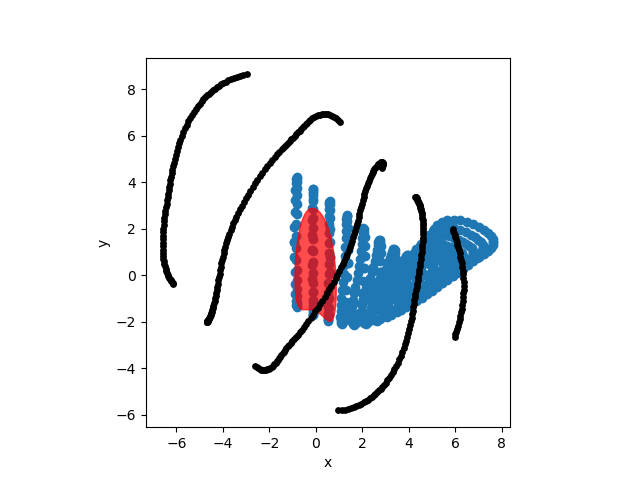

In [56]:
x0 = np.mean(curve_cws.gamma(), axis=0)

gproj = project(vessel.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=0.7)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='k', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')


# Objectives


In [57]:
from simsopt.geo import ProjectedEnclosedArea, ProjectedCurveCurveDistance, ProjectedCurveConvexity, DirectedFacingPort

## ProjectedEnclosedArea

As the name suggests, this is an objective for the area spanned by the curve projected on a plane.

In [58]:
Jarea = ProjectedEnclosedArea( curve_cws, projection='zphi' )

In [59]:
Jarea.J()

Array(3.35164206, dtype=float64)

In [60]:
Jarea.dJ()

array([-1.25477981e+01,  3.28489273e+02, -8.83244534e+00, -9.62885625e+00,
        2.09547577e+02,  1.70038557e+01, -4.81442812e-01, -6.52621895e+00,
        9.57438984e+00, -2.16351532e-01])

Text(0.5, 0, '$\\epsilon$')

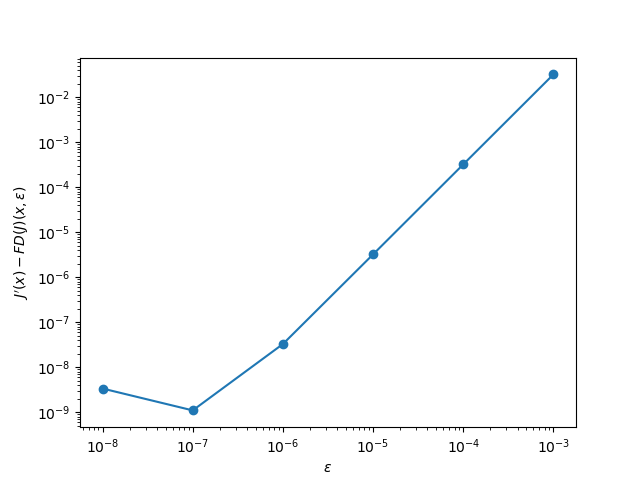

In [61]:
def f(x):
    Jarea.x = x
    return Jarea.J(), Jarea.dJ()

dofs = Jarea.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

## ProjectedCurveCurveDistance

This penalty penalises curves that are too close to the port boundary once projected on a plane. This is heavily inspired from the implementation of `CurveCurveDistance`, excepted that here, only the distance to `curve_cws` is taken into account, the distance is in a plane, and only points that have a component normal to the plane higher than the curve_cws component are accounted for (this effectively removes curve elements behind the plasma)

In [62]:
Jccxydist = ProjectedCurveCurveDistance( curves, curve_cws, .1, projection='zphi' )

In [63]:
for c in curves:
    c.unfix_all()

In [64]:
Jccxydist.J()

Array(1.78534167, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

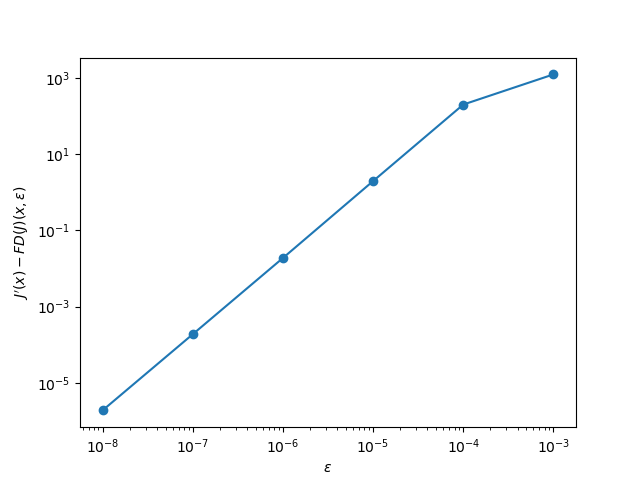

In [70]:
def f(x):
    Jccxydist.x = x
    return Jccxydist.J(), Jccxydist.dJ()

dofs = Jccxydist.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

# Directed facing port

In [66]:
Jufp = DirectedFacingPort(curve_cws, projection='r')
Jufp.J()

Array(10.75651126, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

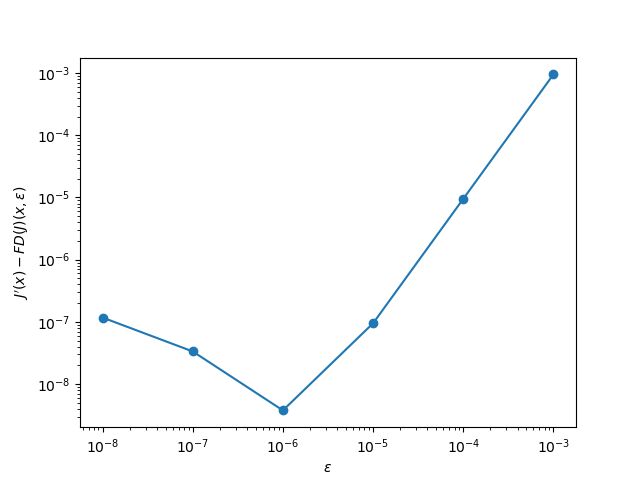

In [67]:
def f(x):
    Jufp.x = x
    return Jufp.J(), Jufp.dJ()

dofs = Jufp.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

# Projected Curve Convexity

In [68]:
Jco = ProjectedCurveConvexity(curve_cws, projection='zphi')
Jco.J()

Array(2.01145703, dtype=float64)

Text(0.5, 0, '$\\epsilon$')

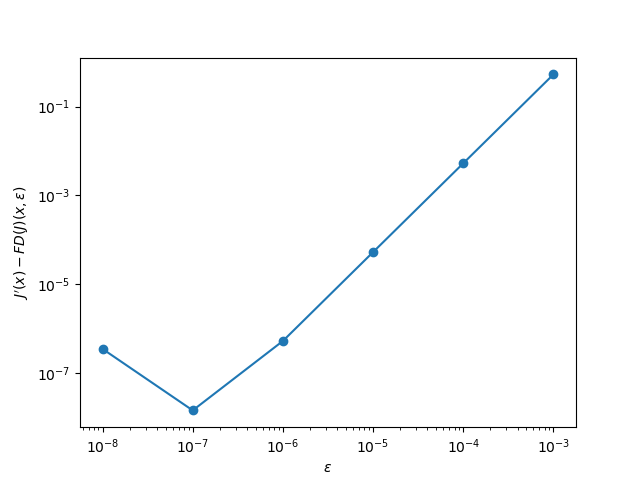

In [69]:
def f(x):
    Jco.x = x
    return Jco.J(), Jco.dJ()

dofs = Jco.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

# Test optimization

We now perform a very simple optimization of the port size. The target function is 
$$
J = A_{xy}(C_0) + J_{cc\_dist}(C_0,\mathbf{C}) + J_{arclength}(C_0),
$$
where $C_0$ is the port boundary, and $\mathbf{C}$ is an array containing all the coils. We fix the boundary dofs and the coils dofs, only the port boundary is a free parameter. We initialize the port close to where the maximum port size was found using the vertical port discrete class.

In [22]:
from scipy.optimize import minimize
from simsopt.geo import ArclengthVariation

Text(0, 0.5, 'y')

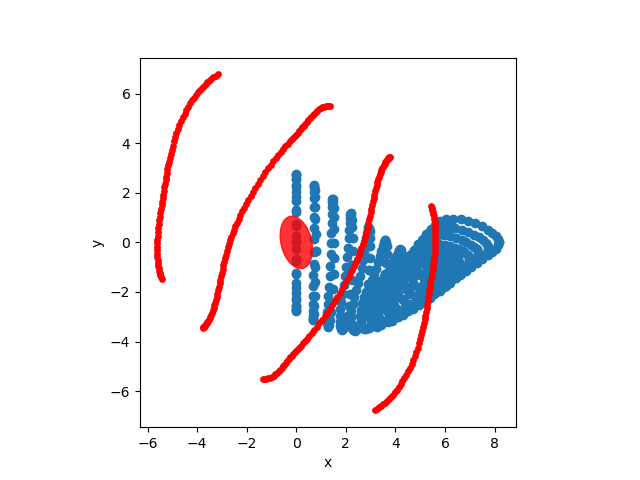

In [23]:
order = 2
qpts = 128
curve_cws = CurveCWSFourier(
    qpts,
    order,
    vessel
)

curve_cws.set('phic(0)', 0.0)
curve_cws.set('phic(1)', 0.007)
curve_cws.set('thetac(0)', 0.0)
curve_cws.set('thetas(1)', 0.05)


x0 = np.mean(curve_cws.gamma(),axis=0)

gproj = project(vessel.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=.8)

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='r', marker='o', s=15)

ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

In [24]:
# Define the objective function
bs = load( 'coils.wiedman.json' )
ncoils = 5
curves = [c.curve for c in bs.coils[0:2*ncoils] + bs.coils[-ncoils:]]


Jxyarea = ProjectedEnclosedArea( curve_cws, projection='zphi' )
Jccxydist = ProjectedCurveCurveDistance( curves, curve_cws, 0.5, projection='zphi' )
Jconvex = ProjectedCurveConvexity( curve_cws, projection='zphi' )
Jarc = ArclengthVariation( curve_cws )
Jufp = DirectedFacingPort(curve_cws, projection='r')

wdd = 1E1
#wco = 1E1
#wph = 1E3
warc = 1E-1
wufp = 1E-1

J = -1*Jxyarea + wdd * Jccxydist + warc * Jarc + wufp*Jufp #+ wco * Jconvex  #+ wph * (Jphimin + Jphimax) + wco * Jconvex # #

def f(x, info={'Nfeval': 0}):
    info['Nfeval'] += 1
    
    J.x = x

    A = Jxyarea.J()
    CC = Jccxydist.J()
    convex = Jconvex.J()
    out = J.J()
    
    nf = info['Nfeval']
    outstr = f"Nfeval: {nf}::  J={out:.2E}, Area={A:.2E}, Coil-coil dist={CC:.2E}, Convex={convex:.2E}, Arclength={Jarc.J():.2E}, Jufp={Jufp.J():.2E}"
    if np.mod(nf,10)==0:
        outstr+="/n"
    print(outstr)
    
    return out, J.dJ()

In [25]:
Jxyarea.J()

Array(1.04125007, dtype=float64)

In [26]:
Jccxydist.J()

Array(0., dtype=float64)

In [27]:
Jconvex.J()

Array(0.11966766, dtype=float64)

In [28]:
Jarc.J()

1.0814347757783873

In [29]:
Jufp.J()

Array(0., dtype=float64)

In [30]:
for c in curves:
    c.fix_all()
curve_cws.unfix_all()

dofs = J.x
f(dofs, {'Nfeval':0})

Nfeval: 1::  J=-9.33E-01, Area=1.04E+00, Coil-coil dist=0.00E+00, Convex=1.20E-01, Arclength=1.08E+00, Jufp=0.00E+00


(Array(-0.93310659, dtype=float64),
 array([-2.16798801e-14, -1.72367400e+02,  1.43773882e-14, -4.02025575e+01,
        -1.07358566e-14, -3.33066907e-17, -5.62835805e+00, -5.61321822e-15,
        -1.22939002e+01,  1.18585697e-15]))

In [31]:
curve_cws.dof_names

['CurveCWSFourier2:phic(0)',
 'CurveCWSFourier2:phic(1)',
 'CurveCWSFourier2:phic(2)',
 'CurveCWSFourier2:phis(1)',
 'CurveCWSFourier2:phis(2)',
 'CurveCWSFourier2:thetac(0)',
 'CurveCWSFourier2:thetac(1)',
 'CurveCWSFourier2:thetac(2)',
 'CurveCWSFourier2:thetas(1)',
 'CurveCWSFourier2:thetas(2)']

In [32]:
MAXITER = 1E4
res = minimize(f, dofs, jac=True, args=({'Nfeval': 0}), method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300}, tol=1e-12)

Nfeval: 1::  J=-9.33E-01, Area=1.04E+00, Coil-coil dist=0.00E+00, Convex=1.20E-01, Arclength=1.08E+00, Jufp=0.00E+00
Nfeval: 2::  J=4.82E+06, Area=-1.16E+01, Coil-coil dist=4.81E+05, Convex=2.59E+03, Arclength=3.23E+04, Jufp=0.00E+00
Nfeval: 3::  J=-9.33E-01, Area=1.04E+00, Coil-coil dist=0.00E+00, Convex=1.20E-01, Arclength=1.08E+00, Jufp=0.00E+00
Nfeval: 4::  J=-2.32E+00, Area=2.84E+00, Coil-coil dist=0.00E+00, Convex=1.68E-01, Arclength=5.21E+00, Jufp=0.00E+00
Nfeval: 5::  J=5.13E+03, Area=4.10E+00, Coil-coil dist=5.13E+02, Convex=1.78E-01, Arclength=1.17E+01, Jufp=0.00E+00
Nfeval: 6::  J=-2.32E+00, Area=2.84E+00, Coil-coil dist=0.00E+00, Convex=1.68E-01, Arclength=5.21E+00, Jufp=0.00E+00
Nfeval: 7::  J=1.31E+03, Area=3.65E+00, Coil-coil dist=1.32E+02, Convex=1.75E-01, Arclength=9.20E+00, Jufp=0.00E+00
Nfeval: 8::  J=-2.38E+00, Area=2.95E+00, Coil-coil dist=0.00E+00, Convex=1.69E-01, Arclength=5.71E+00, Jufp=0.00E+00
Nfeval: 9::  J=3.13E+02, Area=3.41E+00, Coil-coil dist=3.16E+01, C

In [33]:
res.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

Text(0.5, 0, '$\\epsilon$')

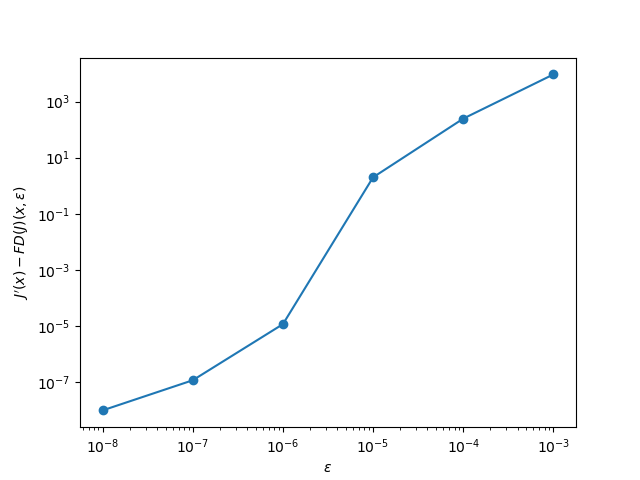

In [34]:
JJ = Jccxydist #Jarc #Jufp

def f(x):
    JJ.x = x
    return JJ.J(), JJ.dJ()

dofs = JJ.x
np.random.seed(1)
h = np.random.uniform(size=dofs.shape)
J0, dJ0 = f(dofs)
dJh = sum(dJ0 * h)
myeps = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7,1e-8]
myerr=[]
for eps in myeps:
    J1, _ = f(dofs + eps*h)
    J2, _ = f(dofs - eps*h)
    myerr.append( (J1-J2)/(2*eps) - dJh )

plt.figure()
plt.loglog(myeps, np.abs(myerr), marker='o')
plt.ylabel(r"$J'(x)-FD(J)(x,\epsilon)$")
plt.xlabel(r"$\epsilon$")

In [35]:
Jccxydist.J()

Array(0.00013752, dtype=float64)

In [36]:
Jxyarea.J()

Array(7.55103336, dtype=float64)

In [37]:
Jconvex.J()

Array(0.11895757, dtype=float64)

In [38]:
Jarc.J()

6.360554667413657

In [39]:
Jufp.J()

Array(0., dtype=float64)

In [40]:
curve_cws.set('thetac(0)',0.01)

Text(0, 0.5, 'y')

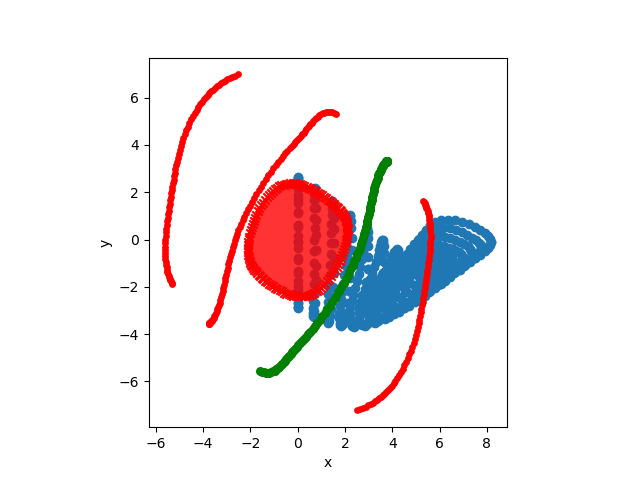

In [41]:
x0 = np.mean(curve_cws.gamma(),axis=0)

gproj = project(vessel.gamma().reshape((-1,3)), x0)

fig, ax = plt.subplots()
ax.scatter(gproj[:,1],gproj[:,2])

gport = project(curve_cws.gamma(), x0)
ax.fill(gport[:,1], gport[:,2], color='r', alpha=.8)
ax.scatter(gport[:,1], gport[:,2], color='r', marker='x')

rf = curve_cws.rfactor()
ind = np.where(rf<0)
ax.scatter(gport[ind,1], gport[ind,2], color='g', marker='o')

for c in curves:
    g = project(c.gamma(), x0)
    zcurves = g[:,0]

    ind = np.where( zcurves>0 )[0]
    g = g[ind,:]

    ax.scatter(g[:,1], g[:,2], color='r', marker='o', s=15)

c = curves[0]
g = project(c.gamma(), x0)
zcurves = g[:,0]

ind = np.where( zcurves>0 )[0]
g = g[ind,:]

ax.scatter(g[:,1], g[:,2], color='g', marker='o', s=30)


ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

Great! This seems to work as expected. We can now try a stage II optimization, where we target a larger port size while keeping the field error small...